#Algoritimo Genético Para Sintonia de MLPRegressor

##Declarações Globais

In [109]:
!pip install -U scikit-learn 

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from math import *
from sklearn.model_selection    import train_test_split,RepeatedStratifiedKFold 
from sklearn.preprocessing      import StandardScaler        #Normalização dos dados
from sklearn.decomposition      import PCA                   #Redução de Dimencionalidade
from sklearn.pipeline           import make_pipeline         #Pipe Line
from sklearn.neural_network     import MLPRegressor
from sklearn.metrics            import mean_absolute_percentage_error

from sklearn.model_selection    import GridSearchCV
#from sklearn.svm import SVC

import os
import glob
import shutil

seed = 170696
sns.set()
sns.set_theme()

In [111]:
path  = '/tmp/'
patha = path  + 'arca/'
pathb = patha + 'bkp/'
urla  = patha + 'arca.csv'
urld  = path  + 'dfConsumo_clima2.csv'

## Dados

In [7]:
df = pd.read_csv(urld)
d = df.iloc[:,2:-3]
d.head()

,Consumo,Ano,Mês,Dias com Precipitação,Precipitação,Pressão,Temperatura,Vento Máx,Vento Méd
0,339480.0,2013,1,9.083333,117.477778,976.542712,22.323023,9.236111,3.053842
1,414663.0,2013,2,13.777778,148.188889,975.360036,22.569606,9.458333,2.835475
2,323379.0,2013,3,13.527778,146.822222,977.684966,19.726666,9.613889,2.849183
3,254855.0,2013,4,11.055556,119.877778,978.880230,18.709059,8.636111,2.475605
4,212174.0,2013,5,15.527778,110.616667,979.065763,15.344357,9.613889,2.375910


In [9]:
X_train = d.iloc[:-12,].drop('Consumo', axis =1)
y_train = d['Consumo'].iloc[:-12,]

X_test = d.iloc[-12:,].drop('Consumo', axis =1)
y_test = d['Consumo'].iloc[-12:,]

## Funções

###Genéticas

In [112]:
def inicializa_populacao(pop_tamanho, n_genes, limites):
    """
    Inicializa a população de acordo com o tamanho da população
    e número de genes.

    param pop_tamanho:     Número de individuos na população
    param n_genes:         Número de genes (Variáveis) no problema
    param limites:         Tupla contendo o número mínimo e máximo permitido  
    return:                Um array numpy com a população iniciada 
                           randomicamente
    """

    pop0 = np.random.randint(
      limites[0], limites[1], size=(pop_tamanho, n_genes)
    )
    pop=[]
    for e, i in enumerate(pop0):
        if np.sum(i) == 0:
            n = np.random.randint(limites[0]+1, limites[1], size=(1, n_genes))
            #print(e,i,n)
            pop.append(n)
        else:    
            pop.append(i)
    return pop

In [113]:
def func_aptidao(individual):
    """
    Calcula a aptidão de cada individuo

    :param individual:   Cromosomo de genes representando um individuo
    :return:             A aptidão individual
    """
    
    hidden_layer_sizes = individual[np.argwhere(individual)].ravel()
    print('\t   Camadas Ocultas = ',hidden_layer_sizes)

    pipe_mlp = make_pipeline(StandardScaler(),                
                        MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                                    activation='relu',
                                    random_state=1,
                                    max_iter=100_000,
                                    alpha = 0.0001,
                                    learning_rate_init = 0.001,
                                    shuffle = True,
                                    beta_1 = 0.94,
                                    beta_2 = 0.999,
                                    epsilon = 0.000_000_000_1,
                                    n_iter_no_change=1000,
                                    solver='adam',
                                    verbose = False,
                                    
                                    )
                        )

    pipe_mlp.fit(X_train, y_train)
    y_pred = pipe_mlp.predict(X_test)

    mape = mean_absolute_percentage_error(y_test,y_pred)
    apti = 1-mape
    print('\t\t','mape','|',mape, '||', 'aptidão','|',apti)

    return mape, apti

In [114]:
def selecao_de_progenitores(individuos, probabilidades, pares):
    """
    Seleciona os pais de acordo com a estratégia "roulette_wheel" que seleciona 
    individuos aleatoriamente utilizando a maior aptidão como maior 
    probabilidade 
    
    param individuos:       Numero de individuos
    param probabilidades:  distribuíção de probabilidade
    return:                pares escolhidos aleatoriamente
    """
    n = len(individuos)
    pares = int(pares)
    if pares*2 > n:
        pares = n/2
    
    p1, p2 = None, None
    pn = np.random.choice(range(n),2*pares, replace = False,p=probabilidades)
    pr = np.random.choice(pn,len(pn),replace=False)
    pp = np.array(pr).reshape(ceil(len(pn)/2),2)

    print('\t\t',pp)   
    return pp

In [115]:
def cruzamento(casal, populacao, ng):
    '''
    param casal:     index tupla (p1,p2) do casal que ira cruzar
    param populacao: recebe a popopulação atual 

    return:          2 filhos com os cruzamentos aleatórios dos genes 
    '''
    p1 = casal[0]   #progenitor 1
    p2 = casal[1]   #progenitor 2
    f1 = []         #filho 1
    f2 = []         #filho 2
    ng = populacao[p1].shape[0]

    print('\t\tpar --', casal,'------')
    print('\t\tp:',p1,populacao[p1]) #p1
    print('\t\tp:',p2,populacao[p2]) #p2

    s1=np.ones(ng)
    while(s1.sum()==ng or s1.sum()==0):   # garantia de que havera ao menos 
        s1=np.random.choice([0,1],ng)    # 1 cruzamento
    print('\t\txxx ', s1)
    for i, b in enumerate(s1):
        #print(i,b)
        if b:
            #print(x[7][i])
            f1.append(populacao[p1][i])
            f2.append(populacao[p2][i])
        else:
            #print(x[9][i])
            f1.append(populacao[p2][i])
            f2.append(populacao[p1][i])
    print('\t\tf1  ',f1)
    print('\t\tf2  ',f2)
    return np.array(f1),np.array(f2)

In [116]:
#mutacao
def mutacao(original, proba_mut, ng):
    '''
    apartir de um individuo original será gerado 1 individuo mutante
    
    param original:     cromossomo do individuo original
    param proba_mut:    probabilidade de mutação 
    return:             mutante
    '''
    mutante = [] 
    print('\t\tori ', original)
    
    gm = np.random.choice(64,ng)    #Sequencia mutante Aleatória

    s1=np.ones(ng)
    while(s1.sum()==0):   # garantia de que havera ao menos 
        s1=np.random.choice([0,1],ng,p=[1-proba_mut,proba_mut])    # 1 mutação
    print('\t\txxx ', s1)
    for i, b in enumerate(s1):
        #print(i,b)
        if b:
            #print(x[7][i])
            mutante.append(gm[i])
            
        else:
            mutante.append(original[i])
            
    print('\t\tmut ',mutante)

    return  np.array(mutante)

###Busca e Salvamento 

In [117]:
def busca_item_lista(_item, _lista):
    '''
    Percorre a lista de arrays e retorna a posição se encontrar ou false se 
    não enontrar 
    
    '''
    for index, it in enumerate(_lista): 

        #print(index,it,_item, all(it==_item))
        if (all(it==_item)):
            return True, index
    return False, False

In [118]:
def salva_arca(_ep,idtest):
    now = datetime.now().strftime('_%y_%m_%d-%H_%M_')
    url = patha + 'arca' +str(idtest)+ now + str(_ep) + '.csv'
    #arca = pd.DataFrame([arca_gen,arca_mape,arca_apt]).T
    arca = pd.DataFrame(dic_arca).T.iloc[:,-3:]   
    arca.columns = ['gen','mape','apt']
    arca.apt = 1-arca.mape  #correção de aptidão relativa para geral
    arca.to_csv(url,index=False)

In [119]:
def recupera_arca():
    '''
    Recupera dados de testes passados
    
    return: arca_gen, arca_mape, arca_apt, dic_arca, dic_arca_i
    '''
    url = patha + 'arca.csv'
    arca_gen_str = pd.read_csv(url).gen.to_list()
    arca_mape    = pd.read_csv(url).mape.to_list()
    arca_apt     = pd.read_csv(url).apt.to_list()

    arca_gen = []
    for e, arc_g in enumerate(arca_gen_str):
        arca_gen.append(gene_str2numpy(arc_g))
    print(len(arca_gen))
    dic_arca = {} # Cria dicionário vazio. # set() = conjunto vazio
    dic_arca_i = {} 
    for e, i in enumerate(arca_gen):
        dic_arca[tuple(i)] = [e,i,arca_mape[e],arca_apt[e]]
        dic_arca_i[e] = i    

    return arca_gen, arca_mape, arca_apt, dic_arca, dic_arca_i

In [120]:
arca_gen, arca_mape, arca_apt, dic_arca, dic_arca_i = recupera_arca()

29799


In [121]:
len(arca_gen) == len(arca_mape)

True

In [122]:
def gene_str2numpy(_str): 
    '''

    return: np.array com a sequencialida 
    '''
    indice = []
    arn = [] 
    ultimo = 9999
    for i, c in enumerate(_str):
        if ord(c) in (91,32,93):
            if i != ultimo + 1:
                indice.append(i)
            # print(i,c,ord(c),)
                ultimo = i

    for i in range(len(indice)-1):
        n_str =_str[indice[i]+1:indice[i+1]]
        arn.append(int(n_str.strip()))
    return np.array(arn)

In [123]:
def salva_resultado(_ep,_res,_mut,_tempo,_pop,_pop_r,_pop_c,idtest):
    now = datetime.now().strftime('_%y_%m_%d-%H_%M_')
    url = path + 'resultado' +str(idtest)+ now + str(_ep) + '.csv'
    result = pd.DataFrame([_res,_mut,_tempo,_pop,_pop_r,_pop_c]).T
    result.columns = ['Mape','Mutacao','Tempo','Populacao','Pop_Recuperada','Pop_Calculada']
    result.to_csv(url,index = False)

In [124]:
def atualiza_arca(_bol):
    if _bol:
        os.chdir(patha)
        extension = 'csv'
        all_filenames = [i for i in glob.glob('arca*.{}'.format(extension))]
        if len(all_filenames):
            now = datetime.now().strftime('%y_%m_%d-%H_%M')
            url = pathb + 'arca_bkp_' + now + '.csv'
            if os.path.exists(patha+'arca.csv'):
                pd.read_csv(patha+'arca.csv').to_csv(url)
            #combine all files in the list
            combined = pd.concat([pd.read_csv(f) for f in all_filenames ])
            filtred = combined[['gen','mape','apt']].sort_values('mape').drop_duplicates()
            #export to csv
            filtred.to_csv("arca.csv", index=False, encoding='utf-8-sig')
            # move arquivos para o bkp
            for f in all_filenames:
                if f !='arca.csv':
                    shutil.move(patha+f,pathb+f)
                    print(f)

#https://www.freecodecamp.org/news/how-to-combine-multiple-csv-files-with-8-lines-of-code-265183e0854/
#https://datatofish.com/move-file-python/

In [125]:
def df_arca_hist(df):
    '''
    Gera dados únicos para comparativo em histograma, considerando que:
    (3, 2, 0, 1) = (3, 2, 1)
    uma vez que na lógica implementada para arquiterura MLP a camada com 0 
    neurônios é suprimida.
    '''
    arca_hist = df[['gen','mape']]
    arca_hist['gen'] = arca_hist.gen.apply(lambda g: gene_str2numpy(g))
    arca_hist['dim'] = arca_hist.gen.apply(lambda x: np.shape(x)[0])
    arca_hist['gen'] = arca_hist.gen.apply(lambda x: str(x[np.where(x)]))
    arca_hist.drop_duplicates(inplace=True)
    
    return arca_hist[arca_hist.dim != 0]

###Relatórios e Medidas

In [126]:
def time_diff(_T1):
    T2 = datetime.now()
    format = '%H:%M'
    #tdiff = datetime.strptime(T1, format) - datetime.strptime(T2, format)
    tdiff = T2 - T1
    #if tdiff. < 0:
    #    tdiff = timedelta(days = 0,
    #                seconds = tdiff.seconds, microseconds = tdiff.microseconds)
    tdiff.total_seconds
    print( '....tempo transcorrido ', tdiff)
    return tdiff.total_seconds()/60
#

In [127]:
def relatorio_parcial():
    print('__________________RELATÓRIO PARCIAL________________________________'
    ,'\n\t\t Geração                    =', ep                  
    ,'\n\t\t Parado                     =', count_parada        
    ,'\n\t\t Códigos na arca            =', len(arca_gen)
    ,'\n\t\t % da população avaliada    =', f'{(len(arca_gen)/max_comb)*100:.5f} %'
    ,'\n\t\t Tempo médio por geração    =', f'{np.mean(list_tdiff):.5f} %'
    ,'\n\t\t Tempo médio por ind_c      =', f'{sum(list_tdiff)/sum(list_t_pop):.2f} min'
    ,'\n-->Nesta Geração:_____________________________________________________'
    ,'\n\t\t Novos indivíduos Testados  =', sum(list_t_pop_c)                
    ,'|'                                  , f'{(sum(list_t_pop_c)/max_comb)*100:.5f} %'
    ,'\n\t\t Clones indivíduos Testados =', sum(list_t_pop_r)
    ,'\n\t\t Total indivíduos Testados  =', sum(list_t_pop)
    ,'|'                                  , f'{(sum(list_t_pop)/max_comb)*100.:.5f} %'
    #,'\n\t\t Tempo por indivíduos novo  =', f'{sum(list_tdiff)/sum(list_t_pop_c):.2f} min'
    #,'\n\t\t %(indivíduos novo/Testados)=', f'{(sum(list_t_pop_c)/max_comb)*100:.5} %'
    )

    print('--------Melhor desta Geração ----------',
          '\n\t\t MAPE      = ', round(ge_mape_min,6),
          '\n\t\t id_arca   = ', ge_mape_ind         ,
          '\n\t\t gen       = ', ge_mape_gen         )

    print('------------Melhor testado ------------',
          '\n\t\t MAPE      = ', round(ar_mape_min,6),
          '\n\t\t id_arca   = ',  ar_mape_ind        ,
          '\n\t\t gen       = ',  ar_mape_gen        )
    
    fig, axs = plt.subplots(3,2, figsize=(12,15))
       
    sns.lineplot(ax=axs[0,0],x=range(len(res)),y=res)
    axs[0,0].set_title('MAPE mínimo por Geração')
    axs[0,0].set_ylabel('MAPE')
    #axs[0,0].set_xlabel('Geração')
    
    sns.lineplot(ax=axs[1,0],x=range(len(list_mutacao)),y=list_mutacao)
    axs[1,0].set_title('Evolução do Fator de mutação')
    axs[1,0].set_ylabel('Fator de mutação')
    #axs[1,0].set_xlabel('Geração')
    
    sns.lineplot(ax=axs[0,1],x=range(len(list_t_pop)),y=list_t_pop, label = 'total')
    sns.lineplot(ax=axs[0,1],x=range(len(list_t_pop_c)),y=list_t_pop_c, label = 'calculada')
    sns.lineplot(ax=axs[0,1],x=range(len(list_t_pop_r)),y=list_t_pop_r, label = 'recuperada')
    axs[0,1].set_title('Evolução tamanho da população')
    axs[0,1].set_ylabel('Indivíduos')
    #axs[0,1].set_xlabel('Geração')
        
    sns.lineplot(ax=axs[1,1],x=range(len(list_tdiff)),y=list_tdiff)
    sns.lineplot(ax=axs[1,1],x=range(len(list_tdiff)),y=np.mean(list_tdiff))
    axs[1,1].set_title('Perfil de tempo por iteração')
    axs[1,1].set_ylabel('tempo [min]')
    #axs[1,1].set_xlabel('Geração')
        
    sns.histplot(ax=axs[2,0],data=teste_mape, kde=True)
    axs[2,0].set_title('Distribuíção de erro por genoma teste')

    list_t_pop_a = []
    list_t_pop_ca = []
    list_t_pop_ra = []
    for e,i in enumerate(list_t_pop_c):
        list_t_pop_a.append(sum(list_t_pop[:e+1]))
        list_t_pop_ca.append(sum(list_t_pop_c[:e+1]))
        list_t_pop_ra.append(sum(list_t_pop_r[:e+1]))
    sns.lineplot(ax=axs[2,1],x=range(len(list_t_pop_a)),
                 y=list_t_pop_a,label = 'total')
    sns.lineplot(ax=axs[2,1],x=range(len(list_t_pop_ca)),
                 y=list_t_pop_ca, label = 'calculada')
    sns.lineplot(ax=axs[2,1],x=range(len(list_t_pop_ra)),
                 y=list_t_pop_ra,label = 'recuperada')
    #sns.ecfplot(ax=axs[2,1],list_t_pop_t, label = 'indivíduos avaliados')
    axs[2,1].set_title('População acumulada')
    axs[2,1].set_ylabel('Indivíduos')
        
    #arca_hist = df_arca_hist(pd.read_csv(urla))
    #sns.histplot(ax=axs[2,1],data=arca_hist, kde=True)
    #axs[2,1].set_title('Distribuíção de erro por genoma hist.')
 
    plt.suptitle('Resultados dos testes Geração = '+str(ep) , y=.93, fontsize=17)
    plt.show();

In [128]:
#relatorio_parcial()


# Main (Código Principal)

In [ ]:
atualiza_arca(True)

->Algoritmo genético de otimização -----------------------------------
	 Nova Populaçao                         =  True 
	 recupera memória de iterações passadas =  True 
	 Gerações máximas                       =  32 
	 Tamanho da população                   =  10 
	 Número de Genes                        =  4 
	 Limite de valores para cada Gene       =  (0, 64) 
	 Probaabilidade de Mutação inicial      =  0.2 
	 Casais por época                       =  17 
	 Limite de epocas parado no mesmo erro  =  100 
	 Erro Alvo                              =  1e-05 
	 Total de combinações no teste          =  16.0 
	 Tempo de execução estimado em horas    =  16.0 
	 Total de combinações possíveis         =  17850625 
	 Tempo máximo max comb. em anos         =  101.88712899543378
31043
-------------------------------------------------------------------- 
			 31043 codigos recuperados 
			 0.17390 % da população avaliada
-->Inicializa População............................................
Populaçã

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 mape | 0.4970482019208265 || aptidão | 0.5029517980791736
0 # 10 [ 2  3 59 38]
	__Individuo Clone Recuperado da Arca #id: 0
	 arca_apt recuperado: 0.9476208419914184
	 arca_mape recuperado: 0.05237915800858154
0 # 11 [ 2 54 29 52]
	__Individuo Clone Recuperado da Arca #id: 1
	 arca_apt recuperado: 0.9475993442294884
	 arca_mape recuperado: 0.052400655770511485
0 # 12 [ 2 24  8 58]
	__Individuo Clone Recuperado da Arca #id: 2
	 arca_apt recuperado: 0.9460330235163094
	 arca_mape recuperado: 0.05396697648369067
0 # 13 [ 2 28 28 46]
	__Individuo Clone Recuperado da Arca #id: 3
	 arca_apt recuperado: 0.9437661302060422
	 arca_mape recuperado: 0.05623386979395779
0 # 14 [ 2 10 46 26]
	__Individuo Clone Recuperado da Arca #id: 4
	 arca_apt recuperado: 0.9434658778075792
	 arca_mape recuperado: 0.05653412219242085
0 # 15 [ 2 11 54 59]
	__Individuo Clone Recuperado da Arca #id: 5
	 arca_apt recuperado: 0.9432469000349448
	 arca_mape recuperado: 0.05675309996505513
0 # 16 [ 2 56 15 46]
	__In

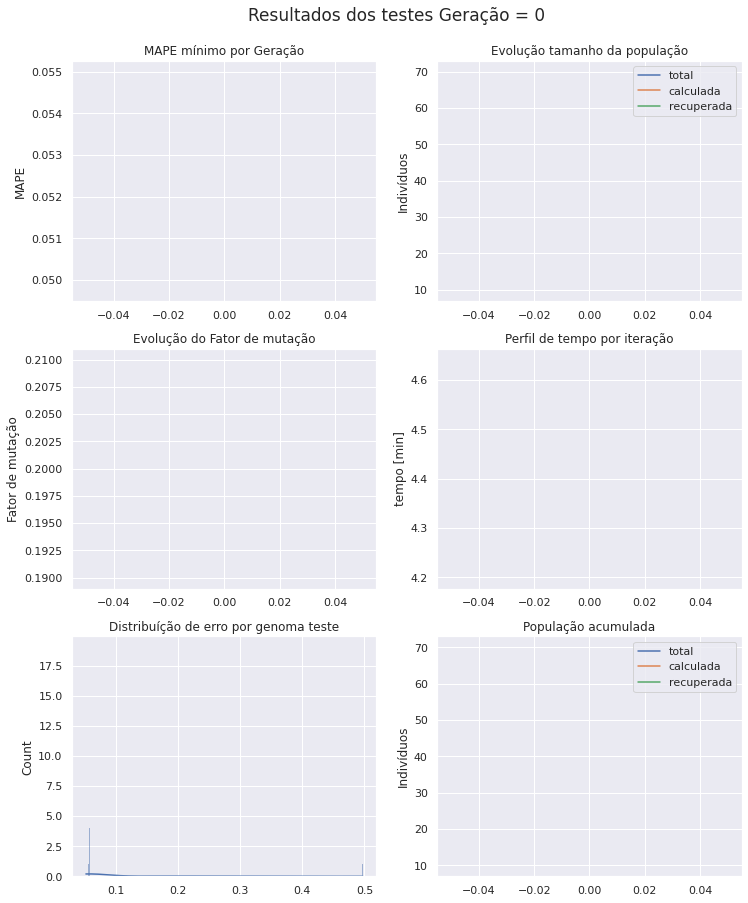

	 Min Erro Atual 0.05238 x 1.00000 Min Erro Anterior
	 parado a 0 epocas
-->>epoca 1 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Projenitores [ 2 56 17 38]
Projenitores [ 2 63 62 16]
Projenitores [ 2 58 29 37]
Projenitores [ 2 56 54 51]
Projenitores [27 47 30 19]
Projenitores [ 2 62 54 52]
Projenitores [ 2 54 44 38]
Projenitores [ 2  3 43 46]
Projenitores [ 2 56 54 52]
Projenitores [ 2 31 29 60]
Projenitores [ 2 54 17 51]
Projenitores [ 2 10 46 26]
Projenitores [ 2 61 54 50]
Projenitores [ 2  3 59 38]
Projenitores [ 2 24  8 58]
Projenitores [45 29 45 43]
Projenitores [60 57  5 21]
Projenitores [ 2 63 38 43]
Projenitores [ 2 56 15 46]
Projenitores [ 2 15 58 62]
Projenitores [ 2 31 48 50]
Projenitores [ 2 11 54 59]
Projenitores [ 2 56 30 56]
Projenitores [ 2 31 17 46]
Projenitores [ 2 56 37 55]
Projenitores [46  2 44  0]
Projenitores [ 2 47 16 54]
Projenitores [ 2 31 29 41]
Projenitores [ 2 56 29 46]
Projenitores [ 

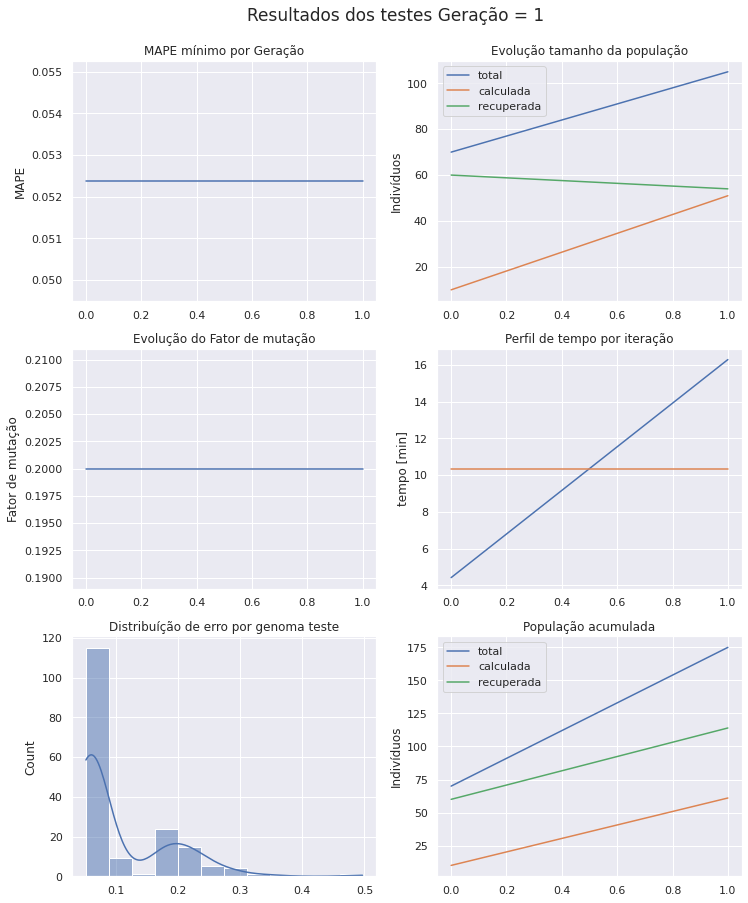

	 Min Erro Atual 0.05238 x 0.05238 Min Erro Anterior
	 parado a 1 epocas
-->>epoca 2 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Projenitores [ 2 47 16 41]
Projenitores [ 2 56 17 38]
Projenitores [ 2 31 17 46]
Projenitores [27 47 30 52]
Projenitores [ 2 58 56 37]
Projenitores [ 2  3 43 46]
Projenitores [45 17 11 35]
Projenitores [ 2 11 54 59]
Projenitores [ 2 56 29 51]
Projenitores [ 2 62 54 19]
Projenitores [ 0 31 14 27]
Projenitores [39 53 22 25]
Projenitores [ 2 31 54 50]
Projenitores [50 51 41 33]
Projenitores [ 2 54 17 51]
Projenitores [ 2 56 55 46]
Projenitores [19 48 54  5]
Projenitores [ 2  3 59 50]
Projenitores [21 57 37  6]
Projenitores [27 13 32 28]
Projenitores [ 2 10 46 26]
Projenitores [46  2 44  0]
Projenitores [ 2 31 29 60]
Projenitores [41 43 31 20]
Projenitores [ 2 63 62 16]
Projenitores [ 2 31 29 54]
Projenitores [ 2 56 54 51]
Projenitores [ 2 11 48 59]
Projenitores [ 2 21 14 30]
Projenitores [ 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 mape | 0.14038788309505043 || aptidão | 0.8596121169049495
2 # 5 [ 2  3 56 37]
	   Camadas Ocultas =  [ 2  3 56 37]
		 mape | 0.0784992626980381 || aptidão | 0.9215007373019619
2 # 6 [ 2 17 54 35]
	   Camadas Ocultas =  [ 2 17 54 35]
		 mape | 0.07841497645629306 || aptidão | 0.921585023543707
2 # 7 [45 11 11 59]
	   Camadas Ocultas =  [45 11 11 59]
		 mape | 0.36904327218316907 || aptidão | 0.6309567278168309
2 # 8 [ 2 62 29 19]
	   Camadas Ocultas =  [ 2 62 29 19]
		 mape | 0.09835495711285176 || aptidão | 0.9016450428871482
2 # 9 [ 2 56 54 51]
	__Individuo Clone Recuperado da Arca #id: 19
	 arca_apt recuperado: 0.9425203581286002
	 arca_mape recuperado: 0.05747964187139973
2 # 10 [ 0 53 14 27]
	   Camadas Ocultas =  [53 14 27]
		 mape | 0.18777758801420363 || aptidão | 0.8122224119857964
2 # 11 [39 31 22 25]
	   Camadas Ocultas =  [39 31 22 25]
		 mape | 0.20582626083191488 || aptidão | 0.7941737391680851
2 # 12 [ 2 31 41 33]
	   Camadas Ocultas =  [ 2 31 41 33]
		 mape | 0.09378

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 mape | 0.07385000213446143 || aptidão | 0.9261499978655385
2 # 32 [60 40  5 17]
	   Camadas Ocultas =  [60 40  5 17]
		 mape | 0.18775733692476512 || aptidão | 0.8122426630752348
2 # 33 [31 57 23 21]
	   Camadas Ocultas =  [31 57 23 21]
		 mape | 0.18001837576033566 || aptidão | 0.8199816242396644
2 # 34 [30 36 45 18]
	   Camadas Ocultas =  [30 36 45 18]
		 mape | 0.1713388226538369 || aptidão | 0.8286611773461631
2 # 35 [18 61 55 60]
	   Camadas Ocultas =  [18 61 55 60]
		 mape | 0.17752825298438038 || aptidão | 0.8224717470156196
2 # 36 [ 8 33 37  5]
	   Camadas Ocultas =  [ 8 33 37  5]
		 mape | 0.22726718338546417 || aptidão | 0.7727328166145359
2 # 37 [ 1 21  8 60]
	   Camadas Ocultas =  [ 1 21  8 60]
		 mape | 0.09453864200377149 || aptidão | 0.9054613579962285
2 # 38 [52 16 20  7]
	   Camadas Ocultas =  [52 16 20  7]
		 mape | 0.20667430517754384 || aptidão | 0.7933256948224562
2 # 39 [61 14 18 60]
	   Camadas Ocultas =  [61 14 18 60]
		 mape | 0.194343739789697 || aptidão | 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 mape | 0.9997149482725333 || aptidão | 0.00028505172746673413
2 # 56 [42 62  1 26]
	   Camadas Ocultas =  [42 62  1 26]
		 mape | 0.1875259445873322 || aptidão | 0.8124740554126678
2 # 57 [42 13 27 40]
	   Camadas Ocultas =  [42 13 27 40]
		 mape | 0.23264641076810186 || aptidão | 0.7673535892318981
2 # 58 [21 23  8 40]
	   Camadas Ocultas =  [21 23  8 40]
		 mape | 0.24939368003989582 || aptidão | 0.7506063199601042
2 # 59 [61 50 41 17]
	   Camadas Ocultas =  [61 50 41 17]
		 mape | 0.17606793508703403 || aptidão | 0.823932064912966
2 # 60 [38 20 37 49]
	   Camadas Ocultas =  [38 20 37 49]
		 mape | 0.2196280216009585 || aptidão | 0.7803719783990415
2 # 61 [ 4 16 33 14]
	   Camadas Ocultas =  [ 4 16 33 14]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 mape | 0.3928817087606061 || aptidão | 0.607118291239394
2 # 62 [ 4 56 24 56]
	   Camadas Ocultas =  [ 4 56 24 56]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 mape | 0.9822424998621072 || aptidão | 0.01775750013789279
2 # 63 [31 62 18 50]
	   Camadas Ocultas =  [31 62 18 50]
		 mape | 0.17830961545112903 || aptidão | 0.821690384548871
2 # 64 [59  5 38 34]
	   Camadas Ocultas =  [59  5 38 34]
		 mape | 0.20611316583702086 || aptidão | 0.7938868341629791
2 # 65 [19 27 36 11]
	   Camadas Ocultas =  [19 27 36 11]
		 mape | 0.22072240411500613 || aptidão | 0.7792775958849939
2 # 66 [47 26 55 63]
	   Camadas Ocultas =  [47 26 55 63]
		 mape | 0.2840774237606036 || aptidão | 0.7159225762393964
2 # 67 [56 21 54  0]
	   Camadas Ocultas =  [56 21 54]
		 mape | 0.18970393690084433 || aptidão | 0.8102960630991557
2 # 68 [44 62 51 35]
	   Camadas Ocultas =  [44 62 51 35]
		 mape | 0.21665518477762194 || aptidão | 0.7833448152223781
2 # 69 [33 40  8 30]
	   Camadas Ocultas =  [33 40  8 30]
		 mape | 0.1594984099245896 || aptidão | 0.8405015900754104
2 # 70 [ 2 47 16 41]
	__Individuo Clone Recuperado da Arca #id: 28895
	 arca_apt recuperado: 0.901645042

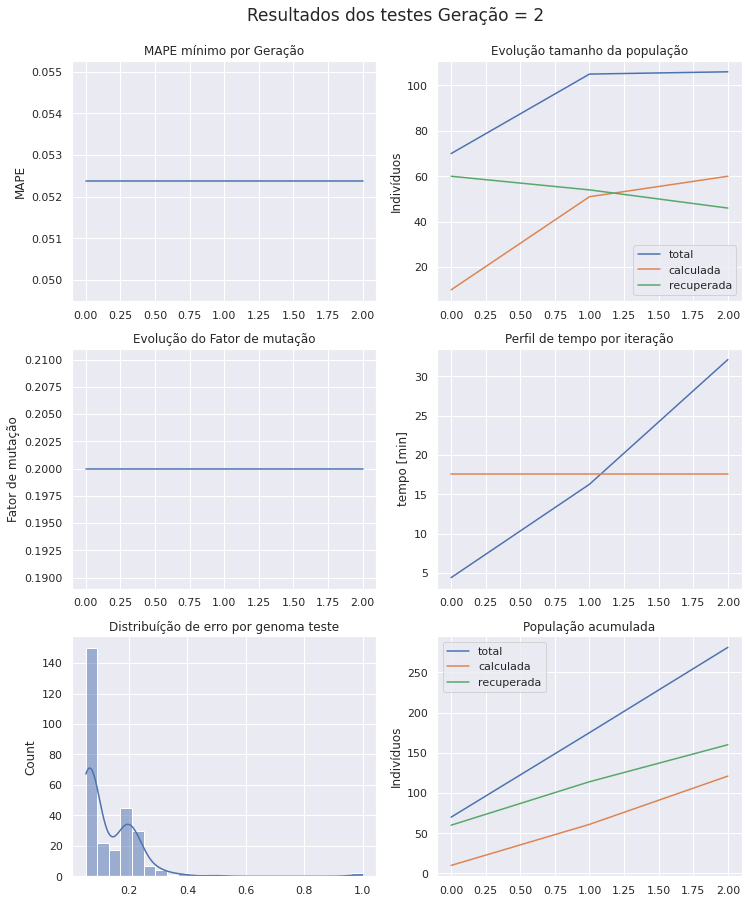

	 Min Erro Atual 0.05238 x 0.05238 Min Erro Anterior
	 parado a 2 epocas
-->>epoca 3 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Projenitores [ 2  3 59 38]
Projenitores [ 2 48 54 50]
Projenitores [ 2 11 48 51]
Projenitores [38 20 37 49]
Projenitores [ 2 62 54 19]
Projenitores [45 11 11 59]
Projenitores [19 48 54  5]
Projenitores [ 2 56 17 46]
Projenitores [ 2 21 14 30]
Projenitores [61 50 41 17]
Projenitores [ 2  3 43 46]
Projenitores [ 8 33 37  5]
Projenitores [44 62 51 35]
Projenitores [ 2 56 54 51]
Projenitores [ 2 56 55 46]
Projenitores [ 2 17 54 35]
Projenitores [46  2 44 26]
Projenitores [ 2 11 54 59]
Projenitores [39 31 22 25]
Projenitores [ 2 31 30 46]
Projenitores [ 2 31 54 50]
Projenitores [33 40  8 30]
Projenitores [50 51 54 50]
Projenitores [56 21 54  0]
Projenitores [27 13 32 28]
Projenitores [ 2 31 41 33]
Projenitores [ 2 11 48 59]
Projenitores [ 2 62 54 52]
Projenitores [ 2  3 56 37]
Projenitores [4

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 mape | 0.30922918963954776 || aptidão | 0.6907708103604522
3 # 43 [45 59 34 63]
	   Camadas Ocultas =  [45 59 34 63]
		 mape | 0.2381833057147957 || aptidão | 0.7618166942852043
3 # 44 [ 7 59 18 26]
	   Camadas Ocultas =  [ 7 59 18 26]
		 mape | 0.14084368454492632 || aptidão | 0.8591563154550736
3 # 45 [19 38 26 52]
	   Camadas Ocultas =  [19 38 26 52]
		 mape | 0.21053478117695193 || aptidão | 0.7894652188230481
3 # 46 [55 51 49 22]
	   Camadas Ocultas =  [55 51 49 22]
		 mape | 0.21265070652897464 || aptidão | 0.7873492934710253
3 # 47 [ 6 55 13  9]
	__Individuo Clone Recuperado da Arca #id: 18450
	 arca_apt recuperado: 0.8033687140706597
	 arca_mape recuperado: 0.19663128592934032
3 # 48 [ 6  1  6 53]
	   Camadas Ocultas =  [ 6  1  6 53]
		 mape | 0.17318211730866004 || aptidão | 0.8268178826913399
3 # 49 [21 57 35 38]
	   Camadas Ocultas =  [21 57 35 38]
		 mape | 0.2094055322275524 || aptidão | 0.7905944677724476
3 # 50 [24 29 17 20]
	   Camadas Ocultas =  [24 29 17 20]
		 map

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 mape | 0.9555289479545164 || aptidão | 0.04447105204548363
3 # 68 [33 17 16 22]
	   Camadas Ocultas =  [33 17 16 22]
		 mape | 0.18039476123900758 || aptidão | 0.8196052387609924
3 # 69 [18 51 11 20]
	   Camadas Ocultas =  [18 51 11 20]
		 mape | 0.23949387850679646 || aptidão | 0.7605061214932035
3 # 70 [ 2  3 59 38]
	__Individuo Clone Recuperado da Arca #id: 0
	 arca_apt recuperado: 0.9476208419914184
	 arca_mape recuperado: 0.05237915800858154
3 # 71 [ 2 48 54 50]
	__Individuo Clone Recuperado da Arca #id: 1454
	 arca_apt recuperado: 0.9215409828947528
	 arca_mape recuperado: 0.07845901710524728
3 # 72 [ 2 11 48 51]
	__Individuo Clone Recuperado da Arca #id: 28952
	 arca_apt recuperado: 0.9016450429178744
	 arca_mape recuperado: 0.09835495708212556
3 # 73 [38 20 37 49]
	__Individuo Clone Recuperado da Arca #id: 28983
	 arca_apt recuperado: 0.7803719783990415
	 arca_mape recuperado: 0.2196280216009585
3 # 74 [ 2 62 54 19]
	__Individuo Clone Recuperado da Arca #id: 1669
	 arca_apt 

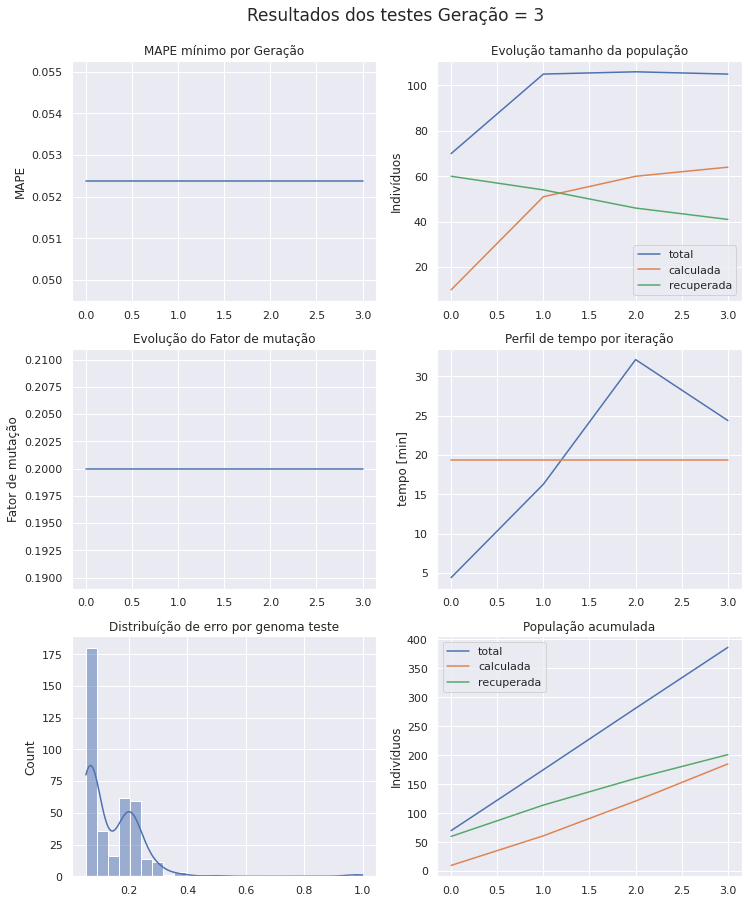

	 Min Erro Atual 0.05238 x 0.05238 Min Erro Anterior
	 parado a 3 epocas
-->>epoca 4 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Projenitores [46  2 44 26]
Projenitores [ 2 40 54 30]
Projenitores [ 2 11 48 59]
Projenitores [33 40  8 30]
Projenitores [ 2 21 14 17]
Projenitores [42 13 27 40]
Projenitores [ 2 56 55 46]
Projenitores [44 62 51 35]
Projenitores [ 2  3 43 46]
Projenitores [ 2 62 54 35]
Projenitores [ 2 17 55 46]
Projenitores [33 17 16 22]
Projenitores [21 14 20 31]
Projenitores [ 2 54 29 52]
Projenitores [25 25  7 54]
Projenitores [42  3 27 40]
Projenitores [ 2  4 14 39]
Projenitores [45 11 11 59]
Projenitores [ 2 62 54 52]
Projenitores [45 17 11 35]
Projenitores [ 2  3 59 38]
Projenitores [ 2 31 30 46]
Projenitores [14 51 18 41]
Projenitores [27 62 55 25]
Projenitores [ 2 31 22 25]
Projenitores [56 21 54 50]
Projenitores [23 61  1 12]
Projenitores [ 2 48 54 50]
Projenitores [19 48 54  5]
Projenitores [3

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 mape | 0.28646753145317755 || aptidão | 0.7135324685468225
4 # 55 [ 6  1  0 42]
	   Camadas Ocultas =  [ 6  1 42]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 mape | 0.47011094001399334 || aptidão | 0.5298890599860067
4 # 56 [18  9 45 48]
	   Camadas Ocultas =  [18  9 45 48]
		 mape | 0.16808204799556548 || aptidão | 0.8319179520044345
4 # 57 [ 0 42  3 31]
	   Camadas Ocultas =  [42  3 31]
		 mape | 0.2261058190561702 || aptidão | 0.7738941809438298
4 # 58 [10 43 50 57]
	   Camadas Ocultas =  [10 43 50 57]
		 mape | 0.2361224068840075 || aptidão | 0.7638775931159925
4 # 59 [ 8  1  3 15]
	   Camadas Ocultas =  [ 8  1  3 15]


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


		 mape | 0.14722336247525378 || aptidão | 0.8527766375247462
4 # 60 [44 58 46  7]
	   Camadas Ocultas =  [44 58 46  7]
		 mape | 0.1835491481739616 || aptidão | 0.8164508518260384
4 # 61 [36 42 25 58]
	   Camadas Ocultas =  [36 42 25 58]
		 mape | 0.22573609231364336 || aptidão | 0.7742639076863567
4 # 62 [53 49 23 11]
	   Camadas Ocultas =  [53 49 23 11]
		 mape | 0.2133533205242207 || aptidão | 0.7866466794757793
4 # 63 [38  3 53 41]
	   Camadas Ocultas =  [38  3 53 41]
		 mape | 0.16801843473534372 || aptidão | 0.8319815652646563
4 # 64 [24 28 39 45]
	   Camadas Ocultas =  [24 28 39 45]
		 mape | 0.27321681073417287 || aptidão | 0.7267831892658272
4 # 65 [37 63 38 37]
	   Camadas Ocultas =  [37 63 38 37]
		 mape | 0.22679920246497717 || aptidão | 0.7732007975350228
4 # 66 [50 15 45 59]
	   Camadas Ocultas =  [50 15 45 59]
		 mape | 0.20243490222976565 || aptidão | 0.7975650977702343
4 # 67 [19 54 57  5]
	   Camadas Ocultas =  [19 54 57  5]
		 mape | 0.18705215284926635 || aptidão |

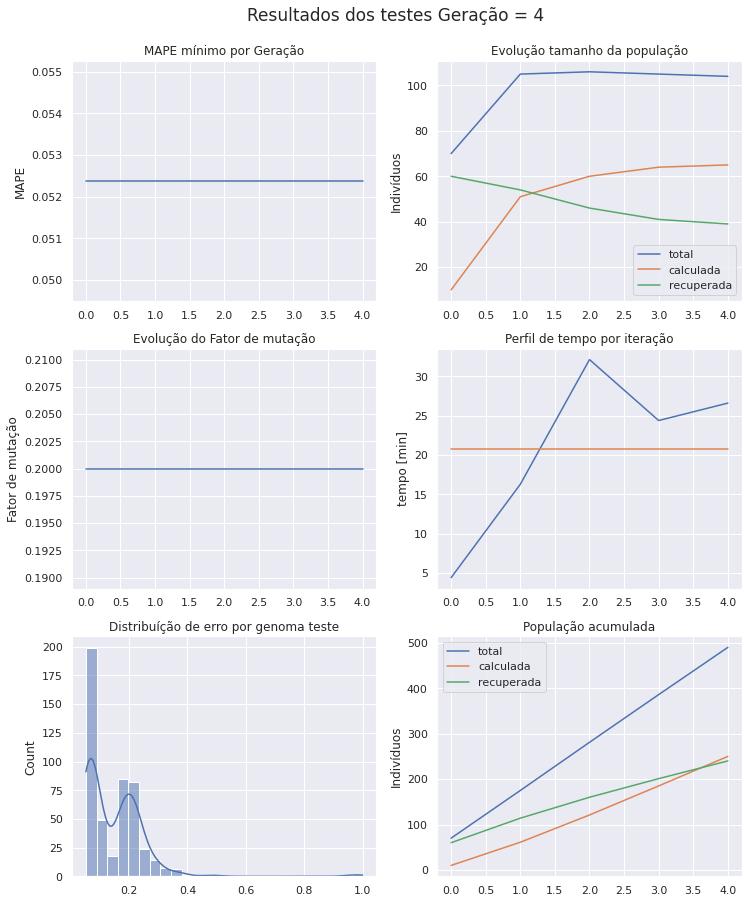

	 Min Erro Atual 0.05238 x 0.05238 Min Erro Anterior
	 parado a 4 epocas
-->>epoca 5 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Projenitores [56 21 54 50]
Projenitores [19 48 54  5]
Projenitores [45 17 54 52]
Projenitores [ 2 40 54 26]
Projenitores [25 25  7 54]
Projenitores [38 11 37  5]
Projenitores [ 2 40 48 59]
Projenitores [21 14 20 31]
Projenitores [45 11 11 59]
Projenitores [49 39 21  6]
Projenitores [21 51  6 28]
Projenitores [38  3 53 41]
Projenitores [46  2 44 30]
Projenitores [10 34  1  4]
Projenitores [ 2  4 14 39]
Projenitores [37  5  3  8]
Projenitores [23 61  1 12]
Projenitores [ 2 21 14 17]
Projenitores [18  9 45 48]
Projenitores [ 2 56 55 46]
Projenitores [ 2  3 30 46]
Projenitores [55 51 49 22]
Projenitores [42 21 27 40]
Projenitores [37 10 34 18]
Projenitores [23 14 59  0]
Projenitores [ 2 40 54 30]
Projenitores [ 2  3 59 38]
Projenitores [25  3  7 54]
Projenitores [ 2 63 27 55]
Projenitores [3

In [ ]:
%%time
# Parâmetros de entrada: 
ini_pop       = True        # Inicializa população aleatória
pop_selecao   = 60          # N melhore hist Selecionados para geração 0 
recup_memo    = True        # True recupera memória de iterações passadas
epocas        = 32          # total de gerações/Epocas
pop_tamanho   = 10          # tamanho da inicial população
n_genes       = 4           # Número de Genes
limites_genes = (0,64)      # Limite de valores para cada Gene
indice_mut    = 0.2         # Probaabilidade de Mutação inicial 
casais        = int((pop_tamanho+pop_selecao)/4)  # Número de casais Progenitores
max_parado    = 100         # Limite de epocas parado no mesmo erro
alvo          = 0.00001     # Erro Alvo

#------------------------------------------------------------------------------
arca_gen        = []           # Memória genetica
arca_apt        = []           # Memória de aptidão 
arca_mape       = []           # Memória de mape 
teste_mape      = []
count_parada    = 0
count_pop_r     = 0
count_pop_c     = 0
res             = []
elite           = []
list_mutacao    = []
list_tdiff      = []
list_t_pop      = []
list_t_pop_r    = []
list_t_pop_c    = []
novos_individuos= []
pre_selecionado = []
selecionado     = []
pop             = []

min_anterior  = 1
test_comb     = epocas*pop_tamanho
max_comb      = ((limites_genes[1]-limites_genes[0])+1)**n_genes

print('->Algoritmo genético de otimização -----------------------------------')
print(  '\t Nova Populaçao                         = '  , ini_pop       ,
      '\n\t recupera memória de iterações passadas = '  , recup_memo    ,
      '\n\t Gerações máximas                       = '  , epocas        ,
      '\n\t Mais aptos selecionados em memória     = '  , pop_selecao   ,
      '\n\t Tamanho da população                   = '  , pop_tamanho   ,
      '\n\t Número de Genes                        = '  , n_genes       ,
      '\n\t Limite de valores para cada Gene       = '  , limites_genes ,
      '\n\t Probaabilidade de Mutação inicial      = '  , indice_mut    ,
      '\n\t Casais por época                       = '  , casais        ,
      '\n\t Limite de epocas parado no mesmo erro  = '  , max_parado    ,
      '\n\t Erro Alvo                              = '  , alvo          ,
      '\n\t Total de combinações no teste          = '  , test_comb/20  ,
      '\n\t Tempo de execução estimado em horas    = '  , test_comb/20  ,
      '\n\t Total de combinações possíveis         = '  , max_comb      ,
      '\n\t Tempo máximo max comb. em anos         = '  , max_comb/175200
      )

if os.path.isfile(patha+'arca.csv') and recup_memo:
    arca_gen, arca_mape, arca_apt, dic_arca, dic_arca_i= recupera_arca()
    print('--------------------------------------------------------------------'
          ,'\n\t\t\t', len(arca_gen),'codigos recuperados'                
          ,'\n\t\t\t', f'{(len(arca_gen)/max_comb)*100:.5f} % da população avaliada' )
 
if ini_pop:
    print('-->Inicializa População............................................')
    pop = inicializa_populacao(pop_tamanho,n_genes,limites_genes)
    print('População Inicial:',pop)
if pop_selecao >0:
    for e, i in enumerate(arca_gen):
        if len(i) ==n_genes:
            pre_selecionado.append(i)
    print (len(pre_selecionado),'possiveis de seleção')    
    for e, i in enumerate(pre_selecionado[0:pop_selecao]):
        print (e,i, len(i))
        selecionado.append(i)
    pop += selecionado
for ep in range(epocas):
    T1 = datetime.now()
    gera_mape = []
    count_pop_r = 0
    count_pop_c = 0
    print('-->>epoca',ep,'----------------------------------------------------')
    #print('Novos Individuos:',novos_individuos)
    if ep > 0: 
        print('-->>>Seleção---------------------------------------------------')
        for i in progenitores.ravel():
            # Progenitores selecionados aleatóriamente  #####
            novos_individuos.append(pop[i])
            print("Projenitores", pop[i])
        for el in range(2):
            # Elite garantindo os 2 melhores da geração anterior
            bol, pos = busca_item_lista(elite[el],novos_individuos)
            if not bol:
                print('\t\t VIP', elite[el])
                novos_individuos.append(elite[el])
        pop = novos_individuos
        novos_individuos = []
    list_t_pop.append(len(pop))
    #print('Novos Individuos:',novos_individuos)
    probabilidades = []  
    print('-->>>Aptidão-------------------------------------------------------')
    for id, individuo in enumerate(pop):
        print(ep,'#', id, individuo)
        #bag, ibag = busca_item_lista(individuo, arca_gen)
        if tuple(individuo) in dic_arca:
            print('\t__Individuo Clone Recuperado da Arca #id:',
                  dic_arca[tuple(individuo)][0])
            a = dic_arca[tuple(individuo)][3]
            m = dic_arca[tuple(individuo)][2]
            print('\t arca_apt recuperado:',a)
            print('\t arca_mape recuperado:',m)
            count_pop_r +=1
        else:
            m,a = func_aptidao(individuo)
            dic_arca[tuple(individuo)]=[len(dic_arca),individuo,m,a]
            dic_arca_i[len(dic_arca_i)]=individuo
            arca_gen.append(individuo)
            arca_apt.append(a)
            arca_mape.append(m)
            count_pop_c +=1
        #print(probabilidades)
        probabilidades.append(1-m)
        gera_mape.append(m)
        #print('\t\t individuo mape',individuo,m)
        #print('\t\t',gera_mape)
    list_t_pop_c.append(count_pop_c)
    list_t_pop_r.append(count_pop_r)
    probabilidades /= sum(probabilidades)
    #print('\t população avaliada:', pop)
    print('\t Probabilidades:', np.round(probabilidades,4))
    print('-->>>Elite---------------------------------------------------------')
    
    prob_elite = np.sort(probabilidades).tolist()[-2:]
    elite = [   pop[probabilidades.tolist().index(prob_elite[0])],
                pop[probabilidades.tolist().index(prob_elite[1])]]
    print('\t\t Elite :', elite)

    print('-->>>Progenitores--------------------------------------------------')
    progenitores = selecao_de_progenitores(pop, probabilidades, casais) 
    print('-->>>Cruzamento----------------------------------------------------')
    for p in progenitores:
        f1, f2 = cruzamento(p,pop, n_genes)
        novos_individuos.append(f1)
        novos_individuos.append(f2)
    print('Novos Individuos F1:',f1)
    print('Novos Individuos F2:',f2)
    #print('Novos Individuos:',novos_individuos)
    print('-->>>Mutação-------------------------------------------------------')
    # Replicas com Mutação dos filhos 
    mutantes = [] 
    for en, ori in enumerate(novos_individuos):
        mu = mutacao(ori,indice_mut,n_genes)
        mutantes.append(mu)
    novos_individuos += mutantes
    # Replicas com mutação da elite
    mutantes2 = [] 
    print('Novos Individuos:',novos_individuos)
    for en, ori in enumerate(elite):
        mu = mutacao(ori,indice_mut,n_genes)
        mutantes2.append(mu)
    novos_individuos += mutantes2
    print('Novos Individuos:',novos_individuos)
    ## Resultados Parciais ----------------------------------------------------
    teste_mape += gera_mape 
    ge_mape_min = (min(gera_mape))              # Menor erro na geração
    res.append(ge_mape_min)     
    ge_mape_ind = arca_mape.index(ge_mape_min)  
    ge_mape_gen = arca_gen[ge_mape_ind]
    
    list_mutacao.append(indice_mut)             # Indice de proba Mutação
    list_tdiff.append(time_diff(T1))            # Tempo de Processamento 
    
    ar_mape_min = min(arca_mape)     # Menor erro histórico
    ar_mape_ind = arca_mape.index(ar_mape_min)  
    ar_mape_gen = arca_gen[ar_mape_ind]
  
    relatorio_parcial()

    #Salva resultados Parciais    
    idtest = n_genes
    salva_resultado(ep,res,list_mutacao,list_tdiff,list_t_pop,
                    list_t_pop_r,list_t_pop_c,idtest)
    salva_arca(ep,idtest)

    # Critérios de parada
    if ge_mape_min < alvo:
        print('para por atingimento do alvo')
        break
    print(f'\t Min Erro Atual {ge_mape_min:.5f} x {min_anterior:.5f} Min Erro Anterior')
    if round(ge_mape_min,5) == round(min_anterior,5):
        count_parada +=1
        if count_parada > 4:
            if indice_mut < 0.81:
                indice_mut += 0.1
                print('Indice Mutação: ', indice_mut)
                count_parada = 0
        if indice_mut > 0.81:
            indice_mut = 0.8 

        if count_parada > max_parado:
            print('para por atingimento do limite de iterações parado')
            break
    else:
        min_anterior = ar_mape_min  #P/ Prox Laço 
        count_parada = 0
    print(f'\t parado a {count_parada} epocas')
            


print('Parada por maximo de interações: ', ep+1             )
print('Menor Mape  '                     , min(arca_mape)   )
print('Indice Mutação Final: '           , indice_mut       )
atualiza_arca(False)

In [ ]:
#relatorio_parcial()

## Relatórios Extras

In [ ]:
plt.figure(figsize=(16,8))
sns.lineplot(range(len(res)),res)
plt.title('MAPE mínimo por Geração', fontsize=17)
plt.ylabel('MAPE')
plt.xlabel('Geração')
plt.show();

In [ ]:
plt.figure(figsize=(16,8))
sns.histplot(arca_mape, kde=True)
plt.title('Distribuíção de erro por genoma', fontsize=17)
#plt.ylabel('MAPE')
#plt.xlabel('Geração')
plt.show();
display(len(arca_mape))

In [130]:
arca_hist = df_arca_hist(pd.read_csv(urla))
arca_mean = arca_hist.mape.describe()[1]
arca_std = arca_hist.mape.describe()[2]
arca_min = arca_hist.mape.describe()[3]
arca_max =  arca_hist.mape.describe()[7]
arca_hist.mape.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


count    31905.000000
mean         0.188699
std          0.097261
min          0.052379
25%          0.142922
50%          0.183811
75%          0.220060
max          0.999715
Name: mape, dtype: float64

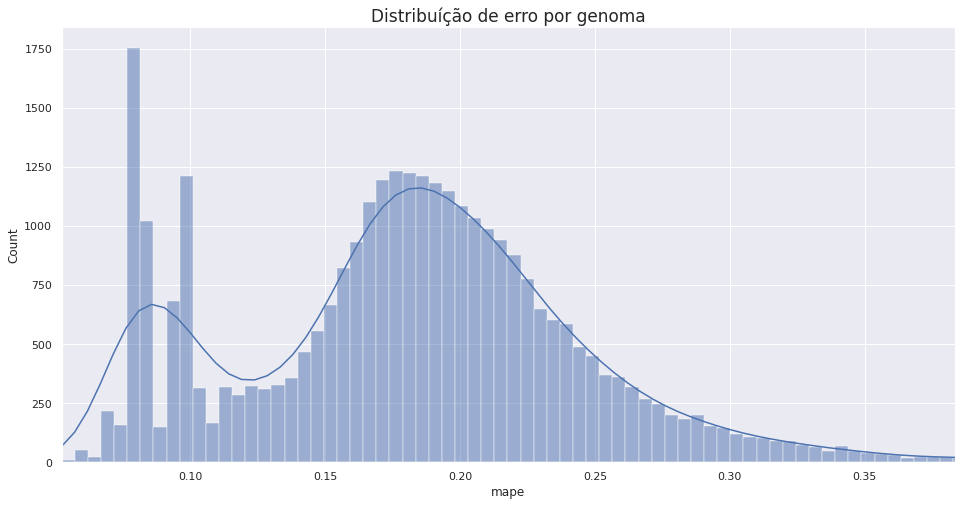

31905

In [155]:
plt.figure(figsize=(16,8))
sns.histplot(arca_hist.mape, kde=True)

plt.title('Distribuíção de erro por genoma', fontsize=17)
#plt.ylabel('MAPE')
#plt.xlabel('Geração')

xinf = max(arca_mean - 2*arca_std,arca_min)
xsup = min(arca_mean + 2*arca_std,arca_max)
plt.xlim(xinf,xsup)
#plt.xlim(0.0779,0.0829)
plt.show();
display(len(arca_hist.mape))


In [89]:
arca_hist = df_arca_hist(pd.read_csv(urla))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


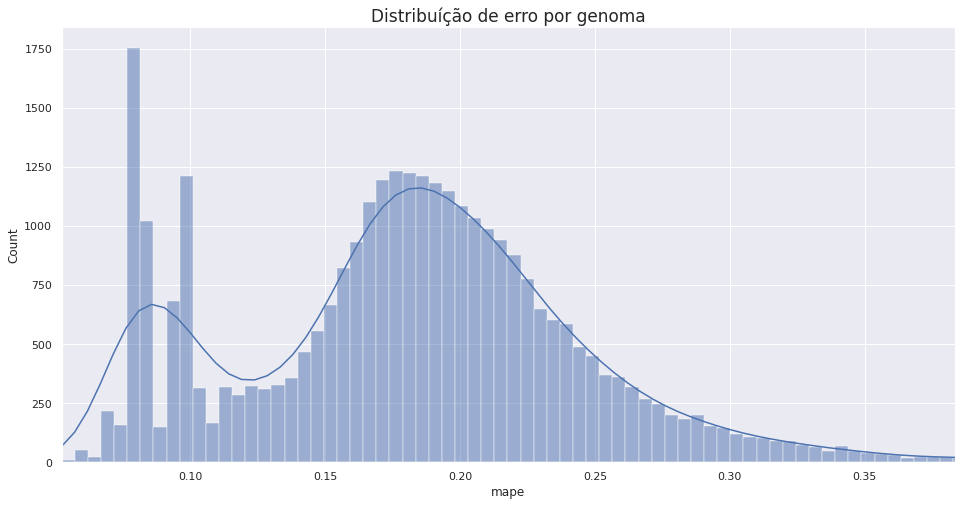

31905

17850625

0.0017873323763173557

0.05237915800858154 0.38322004265627074


In [150]:
plt.figure(figsize=(16,8))

sns.histplot(x = arca_hist.mape, kde=True,palette='Dark2')

plt.title('Distribuíção de erro por genoma', fontsize=17)
#plt.ylabel('MAPE')
#plt.xlabel('Geração')

xinf = max(arca_mean - 2*arca_std,arca_min)
xsup = min(arca_mean + 2*arca_std,arca_max)
plt.xlim(xinf,xsup)
#plt.ylim(0,2000)

plt.show();
display(len(arca_hist.mape),65**4,len(arca_hist.mape)/65**4)
print(xinf, xsup)

In [87]:
arca_hist.to_excel(path+'genhist.csv')

#Fim